## Code Setup

In [1]:
from fastai import *
from fastai.text.all import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown


In [2]:
# Download the data
path = untar_data(URLs.IMDB)
list(path.ls())


[Path('/home/ylek/.fastai/data/imdb/train'),
 Path('/home/ylek/.fastai/data/imdb/imdb.vocab'),
 Path('/home/ylek/.fastai/data/imdb/tmp_lm'),
 Path('/home/ylek/.fastai/data/imdb/README'),
 Path('/home/ylek/.fastai/data/imdb/test'),
 Path('/home/ylek/.fastai/data/imdb/tmp_clas'),
 Path('/home/ylek/.fastai/data/imdb/unsup')]

## Create DataLoaders

Create your dataloaders object and take a look at a batch. It has two columns - the column on the left is some text from movie reviews, and the right column is that same text, just shifted by one word. Later on, using RNNs, you will attempt to generate the sequence on the right using the sequence on the left.

In [3]:
get_imdb = partial(get_text_files, folders=['train', 'unsup'])

lm_dls = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True),
    get_items=get_imdb, splitter=RandomSplitter(0.1)
).dataloaders(path, path=path)


In [4]:
lm_dls.show_batch(max_n=2)

,text,text_
0,xxbos a triumph of xxmaj japanese filmography . xxmaj stand aside xxmaj kurosawa you have been bettered . xxmaj fantastic script and plot - a real family must see . i thought the complete ' xxunk ' was particularly superb . i must comment on the outstanding acting which although must have been done under lots of distractions never wavered and continued to excel throughout . xxmaj the story and script was,a triumph of xxmaj japanese filmography . xxmaj stand aside xxmaj kurosawa you have been bettered . xxmaj fantastic script and plot - a real family must see . i thought the complete ' xxunk ' was particularly superb . i must comment on the outstanding acting which although must have been done under lots of distractions never wavered and continued to excel throughout . xxmaj the story and script was written
1,"nene and he shoots some policemen . xxmaj they make their escape , and xxmaj nene is doing all he can for xxmaj angel . \n\n xxmaj nene has to get the bullet out of xxmaj angle and there is a scene of him digging for the bullet and xxmaj angel screaming in agony , really a great scene and you will think it will never end . xxmaj nene kisses xxmaj","and he shoots some policemen . xxmaj they make their escape , and xxmaj nene is doing all he can for xxmaj angel . \n\n xxmaj nene has to get the bullet out of xxmaj angle and there is a scene of him digging for the bullet and xxmaj angel screaming in agony , really a great scene and you will think it will never end . xxmaj nene kisses xxmaj angle"


## Inputs and Outputs

As you can see in the block below, the inputs are a block of text, and the outputs you're trying to predict is that text shifted by one token. This is similar to the setup in the previous module, where you built RNNs from scratch to predict time series data. The benefit of this setup is that the model can learn about the data in the absence of labels.

Now, look at a single batch of numericalized data. You should make sure that y is x shifted by 1.

In [5]:
x, y = lm_dls.one_batch()

In [6]:
x[0]

LMTensorText([    2,    19,   894,    15,   127,    20,  1514,   120,   339,
                  9,  2228, 20941,    29,    17,    35,     9,     7,  2828,
                 18,     9,  2220,  2687,    15,    17,  1880,    10,    19,
                324,    17,   486,     9,   213,    21,    19,    59,    36,
                 53,     9,  2160,   266,    14,   538,    21,     8,  1859,
                  8,     0,  4534,    37,   777,    15,    41,   468,    31,
                 19,   123,    92,    42,    13,   438,    14,     9,  4442,
                 23,   186,  1742,    28,    20,  2098,    23,   180,    34],
             device='cuda:0')

In [7]:
y[0]

TensorText([   19,   894,    15,   127,    20,  1514,   120,   339,     9,
             2228, 20941,    29,    17,    35,     9,     7,  2828,    18,
                9,  2220,  2687,    15,    17,  1880,    10,    19,   324,
               17,   486,     9,   213,    21,    19,    59,    36,    53,
                9,  2160,   266,    14,   538,    21,     8,  1859,     8,
                0,  4534,    37,   777,    15,    41,   468,    31,    19,
              123,    92,    42,    13,   438,    14,     9,  4442,    23,
              186,  1742,    28,    20,  2098,    23,   180,    34,    10],
           device='cuda:0')

In [8]:
# Check that the same shift occurs for the entire batch
assert (x[:, 1:] == y[:, :-1]).all()

It looks like all your assumptions are true!

## Create the Model

When passing pretrained=True to language_model_learner, you load weights for a language model that was trained on the wikitext103 dataset. Then, like the ULMFiT paper, you will fine-tune this language model on the IMDB dataset.

In [9]:
# Create the model
lm_learn = language_model_learner(lm_dls, AWD_LSTM, pretrained=True)

/home/ylek/miniconda3/envs/fastai/lib/python3.12/site-packages/fastai/text/learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(wgts_fname, map_lo

In [10]:
lm_learn.model


SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60008, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60008, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0-2): 3 x RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60008, bias=True)
    (output_dp): RNNDropout()
  )
)

In [11]:
# The model is trained on wikitext, so it will be able to
# generate semi-sensible sentences, but they will likely
# have nothing to do with movies.
lm_learn.predict('This movie was terrible, ', n_words=10)

'This movie was terrible , as many enchantress reports fixed these movies in its predictions'

In [12]:
LR = 1e-3

In [13]:
lm_learn.fit_one_cycle(1, LR)

epoch,train_loss,valid_loss,time
0,4.419459,4.093943,07:46


In [14]:
lm_learn.predict('This movie was terrible, ', n_words=10)

'This movie was terrible , but past the times it had a likely illuminating effect'

In [15]:
# Save the model
lm_learn.save_encoder('lm_encoder')

In [16]:
# Create dataloaders for text classification.
# Let's make sure to pass your vocab from your pre-training
# so the word indices are the same.
dls = TextDataLoaders.from_folder(path, train='train', valid='test', text_vocab=lm_dls.vocab)

In [17]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxrep 3 * xxmaj warning - this review contains "" plot spoilers , "" though nothing could "" spoil "" this movie any more than it already is . xxmaj it really xxup is that bad . xxrep 3 * \n\n xxmaj before i begin , xxmaj i 'd like to let everyone know that this definitely is one of those so - incredibly - bad - that - you - fall - over - laughing movies . xxmaj if you 're in a lighthearted mood and need a very hearty laugh , this is the movie for you . xxmaj now without further ado , my review : \n\n xxmaj this movie was found in a bargain bin at wal - mart . xxmaj that should be the first clue as to how good of a movie it is . xxmaj secondly , it stars the lame action",neg
2,"xxbos xxmaj polish film maker xxmaj walerian xxmaj borowczyk 's xxmaj la xxmaj bête ( french , 1975 , aka xxmaj the xxmaj beast ) is among the most controversial and brave films ever made and a very excellent one too . xxmaj this film tells everything that 's generally been hidden and denied about our nature and our sexual nature in particular with the symbolism and silence of its images . xxmaj the images may look wild , perverse , "" sick "" or exciting , but they are all in relation with the lastly mentioned . xxmaj sex , desire and death are very strong and primary things and dominate all the flesh that has a human soul inside it . xxmaj they interest and xxunk us so powerfully ( and by our nature ) that they are considered scary , unacceptable and something too wild to be",pos


# Add Callbacks

Set up your model for training. First, you add a few callbacks to save the model and stop it if the validation loss plateaus.

In [18]:
cbs = [
    EarlyStoppingCallback(),
    SaveModelCallback()
]

# Create the Leaner

In the cell below, you create your learner object using your dataloaders for the text classification task and the AWD_LSTM architecture.

In [19]:
# Create a learner for text classification.
learn = text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy, error_rate], cbs=cbs)

/home/ylek/miniconda3/envs/fastai/lib/python3.12/site-packages/fastai/text/learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(wgts_fname, map_lo

# Load Encoder

At this point, your model is the same model that's been pre-trained on wikitext-103, but you want to use the model you fine-tuned on IMDB. You can use the load_encoder method to load the weights you saved. After running this cell, you have an encoder that has been fine-tuned on movie reviews and an untrained classification head.

In [20]:
# Load your weights from fine-tuning on full IMDB
learn = learn.load_encoder('lm_encoder')

/home/ylek/miniconda3/envs/fastai/lib/python3.12/site-packages/fastai/text/learner.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(join_path_file(fil

# Fine Tune the Model

It's time to fine-tune your model for 10 epochs. This means that you will train the classifier only for 1 epoch, then unfreeze the entire model and train for 10 epochs (unless you meet your early stopping criteria).

In [21]:
learn.fine_tune(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.428424,0.345843,0.851480,0.148520,00:35


Better model found at epoch 0 with valid_loss value: 0.34584251046180725.


/home/ylek/miniconda3/envs/fastai/lib/python3.12/site-packages/fastai/text/learner.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.355612,0.290264,0.879680,0.120320,01:06
1,0.313959,0.258504,0.894240,0.105760,01:06
2,0.272798,0.238163,0.904120,0.095880,01:05
3,0.263374,0.219642,0.913000,0.087000,01:05
4,0.261460,0.219322,0.913280,0.086720,01:05
5,0.214934,0.209579,0.919120,0.080880,01:05
6,0.201676,0.208341,0.918440,0.081560,01:05
7,0.204911,0.206182,0.919280,0.080720,01:06
8,0.191858,0.204842,0.919040,0.080960,01:06
9,0.181945,0.204666,0.919200,0.080800,01:06


Better model found at epoch 0 with valid_loss value: 0.2902641296386719.
Better model found at epoch 1 with valid_loss value: 0.25850367546081543.
Better model found at epoch 2 with valid_loss value: 0.23816268146038055.
Better model found at epoch 3 with valid_loss value: 0.21964222192764282.
Better model found at epoch 4 with valid_loss value: 0.21932244300842285.
Better model found at epoch 5 with valid_loss value: 0.20957881212234497.
Better model found at epoch 6 with valid_loss value: 0.20834089815616608.
Better model found at epoch 7 with valid_loss value: 0.20618247985839844.
Better model found at epoch 8 with valid_loss value: 0.2048424929380417.
Better model found at epoch 9 with valid_loss value: 0.20466594398021698.


/home/ylek/miniconda3/envs/fastai/lib/python3.12/site-packages/fastai/text/learner.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location

In [22]:
learn.predict('This movie was horrible!')


('neg', tensor(0), tensor([0.9724, 0.0276]))

In [23]:
learn.predict('This movie was great!')

('pos', tensor(1), tensor([0.0107, 0.9893]))

In [24]:
learn.save('clf_fine_tuned')


Path('/home/ylek/.fastai/data/imdb/models/clf_fine_tuned.pth')

# Model Evaluation

Finally, do a bit of model evaluation. Take a look at the confusion matrix for the validation dataset. For this, you'll use fastai's ClassificationInterpretation object.

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

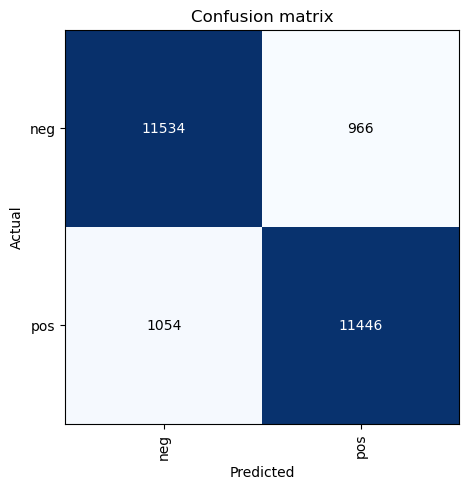

In [26]:
interp.plot_confusion_matrix()

# Top Losses

Another useful way to analyze your model qualitatively is to examine the top losses. This is where the inference differs from the label most strongly and can be useful in identifying samples that might be mislabeled. Take a look at them below. Are any of these labels confusing or possibly wrong?

In [27]:
interp.plot_top_losses(10)

,input,target,predicted,probability,loss
0,"xxbos "" comanche xxmaj moon "" had everything going for it . xxmaj for starters , xxmaj simon xxmaj wincer 's back , a man who 's name is synonymous with high - quality xxup tv westerns . xxmaj unfortunately , the problems with "" moon "" are something even the most talented director could n't solve : a poor script based on a lackluster novel . \n\n xxmaj forget historical accuracies -- as any reader of the novels can tell you , the biggest travesty in "" moon "" is that it 's not even consistent with information from the original "" lonesome xxmaj dove "" masterpiece . xxmaj so many wonderful , rich moments in the miniseries and , to an even greater degree , the book , are completely missing in "" moon . "" xxmaj considering the fact that most viewers of "" moon "" are",pos,neg,0.9996716976165771,9.818175315856934
1,"xxbos * * spoilers xxup ahead * * \n\n xxmaj it is really unfortunate that a movie so well produced turns out to be \n\n such a disappointment . i thought this was full of ( silly ) clichés and \n\n that it basically tried to hard . \n\n xxmaj to the ( american ) guys out there : how many of you spend your \n\n time jumping on your girlfriend 's bed and making monkey \n\n sounds ? xxmaj to the ( married ) girls : how many of you have suddenly \n\n gone from prudes to xxunk overnight -- but not with your \n\n husband ? xxmaj to the xxmaj french : would you really ask about someone \n\n being "" à la xxunk "" when you know they do n't speak xxmaj french ? xxmaj would n't \n\n you use a more common word like "" xxunk",pos,neg,0.9995974898338318,9.716819763183594
2,"xxbos i went to see this 3 nights ago here in xxmaj cork , xxmaj ireland . xxmaj it was the world premiere of it , in the tiny cinema in the xxmaj xxunk xxmaj arts xxmaj centre as part of the xxmaj cork xxmaj film xxmaj festival . \n\n i found "" strange xxmaj fruit "" to be an excellent movie . xxmaj it is a bit rough around the edges , but for a low - budget movie that is to be expected ! xxmaj in general the acting ( particularly from the main lead xxmaj kent xxmaj xxunk ) is wonderful , the cinematography and direction excellent , and the script hugely entertaining and thought - provoking , with some nice set - ups and witty dialogue . \n\n xxmaj the ending was a bit sudden , with no conclusion given to characters and events once the",neg,pos,0.9999455213546753,9.061750411987305
3,"xxbos xxmaj first off let me say , xxmaj if you have n't enjoyed a xxmaj van xxmaj damme movie since bloodsport , you probably will not like this movie . xxmaj most of these movies may not have the best plots or best actors but i enjoy these kinds of movies for what they are . xxmaj this movie is much better than any of the movies the other action guys ( segal and xxmaj dolph ) have thought about putting out the past few years . xxmaj van xxmaj damme is good in the movie , the movie is only worth watching to xxmaj van xxmaj damme fans . xxmaj it is not as good as xxmaj wake of xxmaj death ( which i highly recommend to anyone of likes xxmaj van xxmaj damme ) or xxmaj in hell but , in my opinion it 's worth watching",neg,pos,0.9995548129081726,8.890929222106934
4,"xxbos xxmaj this movie was pure genius . xxmaj john xxmaj waters is brilliant . xxmaj it is hilarious and i am not sick of it even after seeing it about 20 times since i bought it a few months ago . xxmaj the acting is great , although xxmaj ricki xxmaj lake could have been better . xxmaj and xxmaj johnny xxmaj depp is magnificent . xxmaj he is such a beautiful man and a very talented actor . xxmaj and seeing most of xxmaj johnny 's movies , this is probably my favorite . i give it 9.5 / 10 . xxmaj rent it today !",neg,pos,0.9999396800994873,8.832526206970215
5,"xxbos xxmaj this film has the language , the style and the attitude down … plus greats rides from xxmaj xxunk ( a world champ ) and the great xxmaj jerry xxmaj lopez . xxmaj john xxmaj philbin as xxmaj turtle has 